In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

# Creating different geodynamical experiments:

This notebook aims to create different examples of geodymanical experiments as:

- Lithosphere Asthenosphere Boundary (LAB) stability over time

- Wilson cycle - Accordion

- Continental rifting

By choosing one of the experiments above, the following script will automatically create the correct interfaces and boundary conditions to simulate each geodynamic experiment above.

We also implement some strategies to use the final thermal state from a given previous stability experiment as initial temperature field for Wilson Cycle experiments.

The domain of the model comprises 1600 x 700 km<sup>2</sup>, composed of a regular mesh with square elements of 4 x 4 km<sup>2</sup>. However, the user can modify those values to simulate scenarios with higher resolutions
For Wilson cycle and continental rifting experiments, the boundary conditions for the velocity field simulate the lithospheric stretching 
assuming a reference frame fixed on the lithospheric plate on the left side of the model,
and the plate on the right side moves rightward with a velocity of 1 cm/year.
The velocity field in the left and right boundaries of the model is chosen to ensure conservation of mass
and is symmetrical if the adopted reference frame movies to the right with a velocity of 0.5 cm/year relative to the left plate.
Additionally, free slip condition was assumed on the top and bottom of the numerical domain.
To simulate the free surface, the "sticky air" approach (e.g. Gerya and Yuen, 2003b) is adopted,
taking into account a 40-km thick layer with a relatively low viscosity material but with a compatible density with the atmospheric air.
The initial temperature structure is only depth dependent and is 0 ºC at the surface and 1300 ºC at the base of the lithosphere at 130 km.

To avoid artifacts created by a homogeneous rheology, a random perturbation of the initial strain in each finite element of the model (e.g. Brune et al., 2014) is applied.
This random perturbation follows a normal distribution in which the mean initial strain is 0.25 with a standard deviation of 0.08.
Additionally, to ensure the nucleation of rifting at the center of the numerical domain,
a weak seed (e.g. Huismans and Beaumont, 2003) is present in the lithospheric mantle with a constant initial strain of 0.3.


Brune S., Heine C., Pérez-Gussinyé M., Sobolev S. V., Rift migration explains continental margin asymmetry and crustal hyper-extension,
Nature communications, 2014, vol. 5, p. 1.

Gerya T. V., Yuen D. A., Characteristics-based marker-in-cell method with conservative finite-differences schemes for modeling geological flows with strongly variable transport properties, Physics of the Earth and Planetary Interiors, 2003a, vol. 140, p. 293

Huismans R. S., Beaumont C., Symmetric and asymmetric lithospheric extension: Relative effects of frictional-plastic and viscous strain softening, Journal of Geophysical Research: Solid Earth, 2003, vol. 108

# Generate input files

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d


#FUNCITIONS
def read_params(fpath):
    '''
    Read param.txt and returns Nx, Nz, Lx, Lz of the scenario givem by fpath
    
    Parameters
    ----------
    
    fpath: str
        Path to the param.txt file
    '''
    with open(fpath+"param.txt","r") as f:
        line = f.readline()
        line = line.split() #split by space a string to a list of strings
        Nx = int(line[-1])
        
        line = f.readline()
        line = line.split()
        Nz = int(line[-1])

        line = f.readline()
        line = line.split()
        Lx = float(line[-1])

        line = f.readline()
        line = line.split()
        Lz = float(line[-1])

    return Nx, Nz, Lx, Lz

def read_data(prop, step, Nz, Nx, fpath):
    '''
    Read and reshape readed data according to parameters to return a (Nx, Nz) array.
    
    Parameters
    ----------
    
    prop: str
        Property of the mandyoc outputs: temperature, density, strain, strain_rate, viscosity, heat or pressure.
        
    step: str
        Time step of numerical scenario.
        
    Nz: int
        Number of points in z direction.
        
    Nx: int
        Number of points in x direction.
        
    fpath: str
        Path to the param.txt file.
    '''
    
    #build filename
    filename = fpath + prop + "_" + str(step) + ".txt"

    data = np.loadtxt(filename, skiprows=2, unpack=True, comments="P")
    data = np.reshape(data, (Nz, Nx))
    
    return data

# System path

Identifying operational system (Linux or MacOSX)

In [8]:
path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2]

# The code cell bellow will:

## Colect the important scenario information

We will construct a list called `scenario_infos` to create a .txt file containing the most import information about the numerical experiment as:
- Scenario kind: type of geodynamic experiment
- Viscosity scale factors (C) of the layers
- Domain parameters
- Layers thickness

## Define the type of the geodynamic experiment

Here we have six types of geodynamic experiments. You must choose between:

- `'stab'`: Lithosphere Asthenosphere Boundary (LAB) stability over time
- `'stab_keel'`: Lithosphere Asthenosphere Boundary (LAB) stability over time with central cratonic keel
-`'accordion'`: classic Wilson cycle
-`'accordion_lit_hetero'`: Wilson cycle with central weak lithospheric mantle heterogeneity
-`'accordion_keel'`: Wilson cycle with central cratonic keel
-`'quiescence'`: Quiescence with central mobile belt based on Sacek and Salazar-Mora (2021)

Select by ncommenting one of the `scenario_kind` in the cell below

## Setup the numerical scenario according to the selected numerical experiment

Some of parameters changes according to the selected type of experiment, e.g.:
- Layers scale factor of visocisity
- Layer thicknes
- Number of layers
- Temperature boundary conditions
- Velocity boundary conditions

Therefore, for each conditional (`if(scenario_kind == <type_of_experiment>)`) below, we set the main parameters of the respective experiment.

For more information about, please, check de commented lines within the code cell.

In [40]:
# Geodynamic experiments
experiemnts = {'rifting': 'Rifting experiment',
               'stab': 'LAB (1300 oC) stability',
               'accordion': 'Wilson cycle',
               'accordion_lit_hetero': 'Wilson cycle with central weak lithospheric mantle heterogeneity',
               'accordion_keel': 'Wilson cycle with central cratonic keel',
               'stab_keel': 'LAB (1300 oC) stability with central cratonic keel',
               'quiescence': 'Quiescence - central mobile belt',
               }

#Uncomment one of the lines below to select the the kind of tectonic scenario
scenario_kind = 'rifting'
# scenario_kind = 'stab'
# scenario_kind = 'stab_keel'
# scenario_kind = 'accordion'
# scenario_kind = 'accordion_keel'
# scenario_kind = 'accordion_lit_hetero'
# scenario_kind = 'quiescence'

# ncores=20

# print('N cores: '+str(ncores))
# scenario_infos.append('N cores for aguia: '+str(ncores))

#Main parameters used to construct param .txt that changes accordind to
#tectonic regime

####################################
#                                  #
#             Rifting              #      
#                                  #
####################################

if(scenario_kind == 'rifting'):
    #Rheological and Thermal parameters
    C_ast = 1.0
    C_mlit = 10.0
    C_seed = 1.0
    C_lc = 1.0
#     C_lc = 10.0
    C_uc = 1.0
    C_air = 1.0
    
    #Incrase in mantle potential temperature oC
    DeltaT = 0
    # DeltaT = 290 # oC
    
    #Radiogenic heat production (W/kg)
    Hast = 7.38e-12 #Turccote book #original is 0.0
    
    #Use an external temperature field as input
#     preset = True
    preset = False
    
    #Extract the horizontal mean of temperature field from the cratonic keel region
    # keel_center = True
    keel_center = False
    
    #Thins the thicknes of lithospheric mantle below the weak seed
    # extra_fragil = True
    extra_fragil = False
    
    #Apply the horizontal mean of external temperature field to the lithosphere
    # mean_litho = True
    mean_litho = False

#     high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default

    # scenario = 'stable/stable_PT200_rheol19_c1250_C1/'

    # scenario = 'stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst/'
    # scenario = 'stable/lit80km/stable_PT290_rheol19_c1250_C1_HprodAst/'
    # scenario = 'stable/lit80km/stable_PT350_rheol19_c1250_C1_HprodAst/'
    # scenario = 'stable/lit80km/stable_PT400_rheol19_c1250_C1_HprodAst/'
    
    # scenario = 'stable/lit150km/stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/'
    # scenario = 'stable/lit150km/stable_DT290_rheol19_c1250_C1_HprodAst_Hlit150km/'
    scenario = 'stable/lit150km/stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km/'

    # scenario = 'keel/stable_DT200_keel_HprodAst/'

    #Convergence criteria
    denok                            = 1.0e-13
    particles_per_element            = 100

    #Surface constrains
    sp_surface_tracking              = True
    sp_surface_processes             = False 
    
    #time constrains 
    time_max                         = 40.0e6
    # time_max                         = 200.0e6
    step_print                       = 100

    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    # variable_bcv                     = True
    variable_bcv                     = False
    velocity_from_ascii              = True
    

    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False


    #step files
    print_step_files                 = True

    #velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'fixed'         # ok

    # periodic_boundary = True
    periodic_boundary = False
    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free '         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'fixed'          # ok
    right_temperature                   = 'fixed'          # ok

    #Domain parameters
    # total model horizontal extent (m)
    Lx = 1600 * 1.0e3
    # total model vertical extent (m)
    Lz = 700 * 1.0e3 #400 * 1.0e3
    # number of points in horizontal direction
    Nx = 801
    # number of points in vertical direction
    Nz = 176

    # thickness of sticky air layer (m)
    thickness_sa = 40 * 1.0e3
    # thickness of upper crust (m)
    thickness_upper_crust = 20 * 1.0e3
    # thickness of lower crust (m)
    thickness_lower_crust = 15 * 1.0e3
    # total thickness of lithosphere (m)
    thickness_litho = 80 * 1.0e3
    # thickness_litho = 150 * 1.0e3
    # seed depth bellow base of lower crust (m)
    seed_depth = 9 * 1.0e3 #original
    
####################################
#                                  #
#     LAB stability over time      #      
#                                  #
####################################    

elif(scenario_kind == 'stab'):
    #Rheological parameters
    C_ast = 1.0
    C_mlit = 10.0
    C_seed = 1.0
    C_lc = 1.0
#     C_lc = 10.0
#     C_lc = 40.0
    C_uc = 1.0
    C_air = 1.0
    
    #Incrase in mantle potential temperature oC
    DeltaT = 0
    # DeltaT = 290 # oC
    
    #Radiogenic heat production (W/kg)
#     Hast = 0.0
    Hast = 7.38e-12 #Turccote book #original is 0.0
    
    #Use an external temperature field as input
#     preset = True
    preset = False
    
    #Extract the horizontal mean of temperature field from the cratonic keel region
#     keel_center = True
    keel_center = False
    
    #Thins the thicknes of lithospheric mantle below the weak seed
#     extra_fragil = True
    extra_fragil = False
    
    #Apply the horizontal mean of external temperature field to the lithosphere
#     mean_litho = True
    mean_litho = False
    
#     high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default
    
    #Convergence criteria
    denok                            = 1.0e-11
    particles_per_element            = 100
    
    #Surface constrains
    sp_surface_tracking              = True
    sp_surface_processes             = False
    
    #Time constrains  
    time_max                         = 1.0e9 
    step_print                       = 500
    
    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    variable_bcv                     = False
    velocity_from_ascii              = False
    
    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False

    #step_*.txt files
    print_step_files                 = True

    #Velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'free'         # ok

    #Periodic_boundary = True
    periodic_boundary = False
    
    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free'         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #Temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'free'          # ok
    right_temperature                   = 'free'          # ok

    #Domain parameters
    # total model horizontal extent (m)
    Lx = 1600 * 1.0e3
    # total model vertical extent (m)
    Lz = 700 * 1.0e3 #400 * 1.0e3
    # number of points in horizontal direction
    Nx = 161 #401 # #801 #1601
    # number of points in vertical direction
    Nz = 71 #176 #71 #176 #351 #71 #301 #401
    
    #Layers thickness
    # thickness of sticky air layer (m)
    thickness_sa = 40 * 1.0e3
    # thickness of upper crust (m)
    thickness_upper_crust = 20 * 1.0e3
    # thickness of lower crust (m)
    thickness_lower_crust = 15 * 1.0e3
    # total thickness of lithosphere (m)
    # thickness_litho = 80 * 1.0e3
    thickness_litho = 150 * 1.0e3
    # seed depth bellow base of lower crust (m)
    seed_depth = 3 * 1.0e3 #9 * 1.0e3 #original

####################################
#                                  #
# LAB stability with cratonic keel #      
#                                  #
####################################
elif(scenario_kind == 'stab_keel'):
    #Rheological parameters
    C_ast = 1.0
    C_mlit = 10.0
    C_seed = 1.0
    C_lc = 1.0
#     C_lc = 10.0
#     C_lc = 40.0
    C_uc = 1.0
    C_air = 1.0
    
    #Incrase in mantle potential temperature oC
    DeltaT = 0
    # DeltaT = 290 # oC
    
    #Radiogenic heat production (W/kg)
#     Hast = 0.0
    Hast = 7.38e-12 #Turccote book #original is 0.0
    
    #Radiogenic heat production (W/kg)
#     Hast = 0.0
    Hast = 7.38e-12 #Turccote book #original is 0.0
    
    #Use an external temperature field as input
#     preset = True
    preset = False
    
    #Extract the horizontal mean of temperature field from the cratonic keel region
#     keel_center = True
    keel_center = False
    
    #Thins the thicknes of lithospheric mantle below the weak seed
#     extra_fragil = True
    extra_fragil = False
    
    #Apply the horizontal mean of external temperature field to the lithosphere
    mean_litho = True
#     mean_litho = False

#     high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default
    #Path to external scenario to use the temperature field if preset is True

    #Convergence criteria
    denok                            = 1.0e-11
    particles_per_element            = 100
    
    #Surface constrains
    sp_surface_tracking              = True
    sp_surface_processes             = False

    #time constrains 
    time_max                         = 1.0e9
    step_print                       = 500    
    
    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    variable_bcv                     = False
    velocity_from_ascii              = False
    print_step_files                 = True

    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False 

    #step files
    print_step_files                 = True

    #velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'free'         # ok

    # periodic_boundary = True
    periodic_boundary = False

    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free '         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'free'          # ok
    right_temperature                   = 'free'          # ok

    
    # total model horizontal extent (m)
    Lx = 1600 * 1.0e3
    # total model vertical extent (m)
    Lz = 700 * 1.0e3 #400 * 1.0e3
    # number of points in horizontal direction
    Nx = 161 #401 # #801 #1601
    # number of points in vertical direction
    Nz = 71 #176 #71 #176 #351 #71 #301 #401
    
    
    # thickness of sticky air layer (m)
    thickness_sa = 40 * 1.0e3
    # thickness of upper crust (m)
    thickness_upper_crust = 20 * 1.0e3
    # thickness of lower crust (m)
    thickness_lower_crust = 15 * 1.0e3
    # total thickness of lithosphere (m)
    thickness_litho = 80 * 1.0e3
    # seed depth bellow base of lower crust (m)
    seed_depth = 3 * 1.0e3 #9 * 1.0e3 #original
    
####################################
#                                  #
#         Wilson cycle             #      
#                                  #
####################################

elif(scenario_kind == 'accordion'):
    
    #Rheological parameters
    C_ast = 1.0
    C_mlit = 10.0
    C_seed = 1.0
    C_lc = 1.0
#     C_lc = 10.0
#     C_lc = 40.0
    C_uc = 1.0
    C_air = 1.0
    
    #Incrase in mantle potential temperature oC
    DeltaT = 0
    # DeltaT = 290 # oC
    
    #Radiogenic heat production (W/kg)
#     Hast = 0.0
    Hast = 7.38e-12 #Turccote book #original is 0.0
    
    #Radiogenic heat production (W/kg)
#     Hast = 0.0
    Hast = 7.38e-12 #Turccote book #original is 0.0
    
    #Use an external temperature field as input
    preset = True
#     preset = False
    
    #Extract the horizontal mean of temperature field from the cratonic keel region
#     keel_center = True
    keel_center = False
    
    #Thins the thicknes of lithospheric mantle below the weak seed
#     extra_fragil = True
    extra_fragil = False
    
    #Apply the horizontal mean of external temperature field to the lithosphere
    mean_litho = True
#     mean_litho = False

#     high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default
    
    #Path to external scenario to use the temperature field if preset is True
#     scenario = 'stable/stable_PT200_rheol19_c1250_C1/'
#     scenario = 'stable/stable_PT280_rheol19_c1250_C1_HprodAst/'
#     scenario = 'stable/stable_PT290_rheol19_c1250_C1_HprodAst/'
#     scenario = 'keel/stable_DT200_keel_HprodAst/'
    scenario = 'stable/lit150km/stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/'
#     scenario = 'stable/lit150km/stable_DT290_rheol19_c1250_C1_HprodAst_Hlit150km/'
#     scenario = 'stable/lit150km/stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km/'

    #Convergence criteria
    denok                            = 1.0e-13
    particles_per_element            = 100

    #Surface constrains
    sp_surface_tracking              = True
    sp_surface_processes             = False 
    
    #Time constrains 
    time_max                         = 120.0e6
    # time_max                         = 200.0e6
    step_print                       = 100

    #External inputs: bc velocity, velocity field, precipitation and climate change
    variable_bcv                     = True
    velocity_from_ascii              = True

    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False
    
    #step_*.txt files
    print_step_files                 = True

    #Velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'fixed'         # ok

    #Periodic_boundary = True
    periodic_boundary = False
    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free '         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #Temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'fixed'          # ok
    right_temperature                   = 'fixed'          # ok

    #Domain parameters
    # total model horizontal extent (m)
    Lx = 1600 * 1.0e3
    # total model vertical extent (m)
    Lz = 700 * 1.0e3 #400 * 1.0e3
    # Lz = 440 * 1.0e3
    # number of points in horizontal direction
    Nx = 401 #
    # Nx = 801
    # number of points in vertical direction
    Nz = 176  #
    # Nz = 111 #Belon
    # Nz = 351
    
    #Layers thickness
    # thickness of sticky air layer (m)
    thickness_sa = 40 * 1.0e3
    # thickness of upper crust (m)
    thickness_upper_crust = 20 * 1.0e3
    # thickness of lower crust (m)
    thickness_lower_crust = 15 * 1.0e3
    # total thickness of lithosphere (m)
    # thickness_litho = 80 * 1.0e3
    thickness_litho = 150 * 1.0e3
    # thickness_litho = 180 * 1.0e3
    # thickness_litho = 210 * 1.0e3
    # seed depth bellow base of lower crust (m)
    seed_depth = 3 * 1.0e3 #9 * 1.0e3 #original

################################################
#                                              #
# Wilson cycle with heterogeneous lithospheric #
# mantle                                       #      
#                                              #
################################################
elif(scenario_kind == 'accordion_lit_hetero'):
    #Rheological parameters
    C_ast = 1.0
    C_mlit = 10.0
    C_seed = 1.0
    C_lc = 1.0
#     C_lc = 10.0
#     C_lc = 40.0
    C_uc = 1.0
    C_air = 1.0
    
    #Incrase in mantle potential temperature oC
    DeltaT = 0
    # DeltaT = 290 # oC
    
    #Radiogenic heat production (W/kg)
#     Hast = 0.0
    Hast = 7.38e-12 #Turccote book #original is 0.0
    
    #Radiogenic heat production (W/kg)
#     Hast = 0.0
    Hast = 7.38e-12 #Turccote book #original is 0.0
    
    #Use an external temperature field as input
    preset = True
#     preset = False
    
    #Extract the horizontal mean of temperature field from the cratonic keel region
#     keel_center = True
    keel_center = False
    
    #Thins the thicknes of lithospheric mantle below the weak seed
#     extra_fragil = True
    extra_fragil = False
    
    #Apply the horizontal mean of external temperature field to the lithosphere
    mean_litho = True
#     mean_litho = False

#     high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default
    
    #Path to external scenario to use the temperature field if preset is True
#     scenario = 'stable/stable_PT200_rheol19_c1250_C1/'
#     scenario = 'stable/stable_PT280_rheol19_c1250_C1_HprodAst/'
#     scenario = 'stable/stable_PT290_rheol19_c1250_C1_HprodAst/'
#     scenario = 'keel/stable_DT200_keel_HprodAst/'
    scenario = 'stable/lit150km/stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/'
#     scenario = 'stable/lit150km/stable_DT290_rheol19_c1250_C1_HprodAst_Hlit150km/'
#     scenario = 'stable/lit150km/stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km/'

    #Convergence criteria
    denok                            = 1.0e-13
    particles_per_element            = 100

    #Surface constrains
    sp_surface_tracking              = True
    sp_surface_processes             = False 

    #Time constrains 
    time_max                         = 120.0e6
    # time_max                         = 200.0e6
    step_print                       = 100

    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    variable_bcv                     = True
    velocity_from_ascii              = True

    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False

    #Step files
    print_step_files                 = True

    #Velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'fixed'         # ok

    #Periodic_boundary = True
    periodic_boundary = False
    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free '         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #Temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'fixed'          # ok
    right_temperature                   = 'fixed'          # ok

    #Domain parameters
    # total model horizontal extent (m)
    Lx = 1600 * 1.0e3
    # total model vertical extent (m)
    Lz = 700 * 1.0e3 #400 * 1.0e3
    # Lz = 440 * 1.0e3
    # number of points in horizontal direction
    Nx = 401 #
    # Nx = 801
    # number of points in vertical direction
    Nz = 176  #
    # Nz = 111 #Bellon
    # Nz = 351
    
    #Layers thickness
    # thickness of sticky air layer (m)
    thickness_sa = 40 * 1.0e3
    # thickness of upper crust (m)
    thickness_upper_crust = 20 * 1.0e3
    # thickness of lower crust (m)
    thickness_lower_crust = 15 * 1.0e3
    # total thickness of lithosphere (m)
    # thickness_litho = 80 * 1.0e3
    thickness_litho = 150 * 1.0e3
    # thickness_litho = 180 * 1.0e3
    # thickness_litho = 210 * 1.0e3
    # seed depth bellow base of lower crust (m)
#     seed_depth = 3 * 1.0e3 #9 * 1.0e3 #original
    
########################################
#                                      #
#   Wilson cycle with cratonic keel    #      
#                                      #
########################################
elif(scenario_kind == 'accordion_keel'):
    #Rheological parameters
    C_ast = 1.0
    C_mlit = 10.0
    C_seed = 1.0
    C_lc = 1.0
#     C_lc = 10.0
#     C_lc = 40.0
    C_uc = 1.0
    C_air = 1.0
    
    #Incrase in mantle potential temperature oC
    DeltaT = 0
    # DeltaT = 290 # oC
    
    #Radiogenic heat production (W/kg)
#     Hast = 0.0
    Hast = 7.38e-12 #Turccote book #original is 0.0
    
    #Radiogenic heat production (W/kg)
#     Hast = 0.0
    Hast = 7.38e-12 #Turccote book #original is 0.0
    
    #Use an external temperature field as input
    preset = True
#     preset = False
    
    #Extract the horizontal mean of temperature field from the cratonic keel region
#     keel_center = True
    keel_center = False
    
    #Thins the thicknes of lithospheric mantle below the weak seed
#     extra_fragil = True
    extra_fragil = False
    
    #Apply the horizontal mean of external temperature field to the lithosphere
    mean_litho = True
#     mean_litho = False

#     high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default
    
    #Path to external scenario to use the temperature field if preset is True
#     scenario = 'keel/stable_PT200_keel_HprodAst/'
    scenario = 'keel/stable_DT290_keel_HprodAst/'

    #Convergence criteria
    denok                            = 1.0e-13
    particles_per_element            = 100

    #Surface constrains
    sp_surface_tracking              = True
    sp_surface_processes             = False 

    #time constrains 
    time_max                         = 120.0e6 
    step_print                       = 100

    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    variable_bcv                     = True
    velocity_from_ascii              = True

    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False

    #Step files
    print_step_files                 = True

    #Velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'fixed'         # ok

    #Periodic_boundary = True
    periodic_boundary = False
    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free '         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #Temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'fixed'          # ok
    right_temperature                   = 'fixed'          # ok

    #Domain parameters
    # total model horizontal extent (m)
    Lx = 1600 * 1.0e3
    # total model vertical extent (m)
    Lz = 700 * 1.0e3 #400 * 1.0e3
    # number of points in horizontal direction
    # Nx = 401 #
    Nx = 801
    # number of points in vertical direction
    # Nz = 176  #
    Nz = 351
    
    #Layers thickness
    # thickness of sticky air layer (m)
    thickness_sa = 40 * 1.0e3
    # thickness of upper crust (m)
    thickness_upper_crust = 20 * 1.0e3
    # thickness of lower crust (m)
    thickness_lower_crust = 15 * 1.0e3
    # total thickness of lithosphere (m)
    thickness_litho = 80 * 1.0e3
    # seed depth bellow base of lower crust (m)
    seed_depth = 3 * 1.0e3 #9 * 1.0e3 #original
    
####################################
#                                  #
#          Quiescence              #      
#                                  #
####################################
elif(scenario_kind == 'quiescence'):
    #Rheological parameters
    C_ast = 1.0
    C_mlit = 10.0
    C_seed = 1.0
    C_lc = 1.0
#     C_lc = 10.0
#     C_lc = 40.0
    C_uc = 1.0
    C_air = 1.0
    
    #Incrase in mantle potential temperature oC
    DeltaT = 0
    # DeltaT = 290 # oC
    
    #Radiogenic heat production (W/kg)
    Hast = 0.0
#     Hast = 7.38e-12 #Turccote book
    
    #Radiogenic heat production (W/kg)
#     Hast = 0.0
    Hast = 7.38e-12 #Turccote book #original is 0.0
    
    #Use an external temperature field as input
#     preset = True
    preset = False
    
    #Extract the horizontal mean of temperature field from the cratonic keel region
#     keel_center = True
    keel_center = False
    
    #Thins the thicknes of lithospheric mantle below the weak seed
#     extra_fragil = True
    extra_fragil = False
    
    #Apply the horizontal mean of external temperature field to the lithosphere
#     mean_litho = True
    mean_litho = False
    
#     high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default
    
    #Path to external scenario to use the temperature field if preset is True
#     scenario = ''

    #Convergence criteria
    denok                            = 1.0e-11
    particles_per_element            = 100
    
    #Surface constrains
    sp_surface_tracking              = True
    sp_surface_processes             = False

    #time constrains 
    time_max                         = 300.0e6
    step_print                       = 250    
    
    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    variable_bcv                     = False
    velocity_from_ascii              = False

    print_step_files                 = True
    
    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False 

    #step files
    print_step_files                 = True

    #velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'free'         # ok

    # periodic_boundary = True
    periodic_boundary = False

    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free '         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'free'          # ok
    right_temperature                   = 'free'          # ok

    #Domain parameters
    # total model horizontal extent (m)
    Lx = 1600 * 1.0e3
    # total model vertical extent (m)
    Lz = 700 * 1.0e3 #400 * 1.0e3
    # number of points in horizontal direction
    Nx = 161 #401 # #801 #1601
    # number of points in vertical direction
    Nz = 71 #176 #71 #176 #351 #71 #301 #401
    
    #Layers thickness
    # thickness of sticky air layer (m)
    thickness_sa = 40 * 1.0e3
    # thickness of upper crust (m)
    thickness_upper_crust = 15 * 1.0e3
    # thickness of lower crust (m)
    thickness_lower_crust = 15 * 1.0e3
    # total thickness of lithosphere (m)
    thickness_litho = 250 * 1.0e3
    # seed depth bellow base of lower crust (m)
    seed_depth = 3 * 1.0e3 #9 * 1.0e3 #original
    
    
#Creating scenario informations list
scenario_infos = ['SCENARIO INFOS:']
scenario_infos.append(' ')

scenario_infos.append('Type of experiment: ' + experiemnts[scenario_kind])
# scenario_infos.append('Name: ' + path[-1])

#Updatind scneario_infos
scenario_infos.append(' ')
scenario_infos.append('Viscosity scale factors (C):')
scenario_infos.append('C asthenosphere: '+str(C_ast))
scenario_infos.append('C mantle lithosphere: '+str(C_mlit))
scenario_infos.append('C seed: '+str(C_seed))
scenario_infos.append('C lower crust: '+str(C_lc))
scenario_infos.append('C upper crust: '+str(C_uc))
scenario_infos.append('C air: '+str(C_air))

scenario_infos.append(' ')
scenario_infos.append('Preset of initial temperature field: '+str(preset))
if(preset == False):
    scenario_infos.append('Increase in mantle basal temperature (Ta): '+str(DeltaT)+' oC')
scenario_infos.append('Seed extra fragil: ' + str(extra_fragil))
scenario_infos.append('Use horizontal mean of temperature from preset in lithosphere: ' + str(mean_litho))
scenario_infos.append('High kappa in asthenosphere: ' + str(high_kappa_in_asthenosphere))
scenario_infos.append('Surface process: '+str(sp_surface_processes))
scenario_infos.append('Climate change: '+str(climate_change_from_ascii))
scenario_infos.append('Velocity field: '+str(velocity_from_ascii))

scenario_infos.append(' ')
scenario_infos.append('Domain parameters:')
scenario_infos.append('Lx: ' + str(Lx*1.0e-3) + ' km')
scenario_infos.append('Lz: ' + str(Lz*1.0e-3) + ' km')
scenario_infos.append('Nx: ' + str(Nx))
scenario_infos.append('Nz: ' + str(Nz))
scenario_infos.append('Resolution dx x dz: ' + str(int(1.0e-3*Lx/(Nx-1))) + 'x' + str(int(1.0e-3*Lz/(Nz-1))) + ' km2')

scenario_infos.append(' ')
scenario_infos.append('Layers thickness:')
scenario_infos.append('Air: ' + str(thickness_sa*1.0e-3) + ' km')
scenario_infos.append('Upper crust: ' + str(thickness_upper_crust*1.0e-3) + ' km')
scenario_infos.append('Lower crust: ' + str(thickness_lower_crust*1.0e-3) + ' km')
scenario_infos.append('Lithospheric Mantle: ' + str((thickness_litho - thickness_upper_crust - thickness_lower_crust)*1.0e-3) + ' km')
scenario_infos.append('Lithosphere: ' + str(thickness_litho*1.0e-3) + ' km')
scenario_infos.append(' ')

In [41]:
x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)

X, Z = np.meshgrid(x, z)

## Creating interfaces (bottom first)

Here we need a better explanation of what consist the geometry of the more complex scenarios as `'accordion_lit_hetero'`, `'stab_keel'`, `'accordion_keel'` and `'quiescence'`

- `'accordion_lit_hetero'`: The heterogeneity is made by a thinning of lithospheric mantle in the central region until the base of the lower crust. This thinned region is filled by another lithospheric mantle layer that thickens in the thinned region but with lower viscosity scale factor $C$.
                          
- `'stab_keel'` and `'accordion_keel'`: The cratonic keel for both experiments is made by a thickenning of the lithospheric mantle at the central region (`thickness_increment`).

- `'accordion'`: This type of experiment has a simple flat layers with a weak seed inside the lithospheric mantle. However the `extra_fragil` flag decrease the $C_{\mathrm{seed}}$ and creates a drastic thinning of the lithospheric mantle bellow the weak seed to force the concentration of deformation at the weak seed region.

- `'quiescence'`: The geometry consists in a thinning of the lithospheric mantle at the central region of `WTL`= 400 km


In [42]:
if(scenario_kind == 'accordion_lit_hetero'): #There is no need to put a weak seed inside the lithospheric mantle
    interfaces = {
        "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
        "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface between central and lateral
        # "seed_base": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
        # "seed_top": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
        "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
        "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
        "air": np.ones(Nx) * (thickness_sa),
    }

    dx = Lx/(Nx-1)
    M_lit = thickness_litho - (thickness_upper_crust + thickness_lower_crust) #thickness of lithospheric mantle

    Wcenter = 200.0e3 #width of central portion #m
    N_Wcenter = int(Wcenter//dx) #width in indexes

    #thinning for central portion to create the strong mantle lithosphere
    thinning = thickness_litho - M_lit #m
    interfaces['litho_HETERO'][Nx//2 - N_Wcenter//2 : Nx//2 + N_Wcenter//2] = thickness_sa + thinning

else: #All other scenarios have a weak seed within lithospheric mantle
    interfaces = {
        "litho": np.ones(Nx) * (thickness_litho + thickness_sa),
        "seed_base": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
        "seed_top": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
        "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
        "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
        "air": np.ones(Nx) * (thickness_sa),
    }

    # seed thickness (m)
    thickness_seed = 6 * 1.0e3
    # seed horizontal position (m)
    x_seed = 800 * 1.0e3
    # seed: number of points of horizontal extent
    n_seed = 6

    interfaces["seed_base"][
        int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
    ] = (
        interfaces["seed_base"][
            int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
        ]
        + thickness_seed // 2
    )
    interfaces["seed_top"][
        int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
    ] = (
        interfaces["seed_top"][
            int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
        ]
        - thickness_seed // 2
    )

#More complex geometries and specific cases
if(scenario_kind == 'stab_keel' or scenario_kind == 'accordion_keel'):
    #The cratonic keel is defined by a thickenning of lithospheric mantle
    dx = Lx/(Nx-1)
    Lcraton = 600.0e3 #m
    thickness_var = 120.0e3
    thickening = thickness_litho + thickness_var #m
    Ncraton = int(Lcraton//dx) #largura em indices
    interfaces['litho'][Nx//2 - Ncraton//2 : Nx//2 + Ncraton//2] = thickness_sa + thickening

if(scenario_kind == 'accordion' or scenario_kind == 'rifting'):
    if(extra_fragil == True):
        C_seed = 0.01
        dx = Lx/(Nx-1)
        Lfragil = 12.0e3 #m
        # thinning = thickness_litho - 45.0e3
        thinning = thickness_litho - 20.0e3
        Nfragil = int(Lfragil//dx) #largura em indices
        interfaces['litho'][Nx//2 - Nfragil//2 : Nx//2 + Nfragil//2] = thickness_sa + thinning

if(scenario_kind == 'quiescence'):
    dx = Lx/(Nx-1)
    WTL = 400.0e3 #m
    thickness_var = 150.0e3
    thinning = thickness_litho - thickness_var #m
    N_WTL = int(WTL//dx) #largura em indices
    interfaces['litho'][Nx//2 - N_WTL//2 : Nx//2 + N_WTL//2] = thickness_sa + thinning

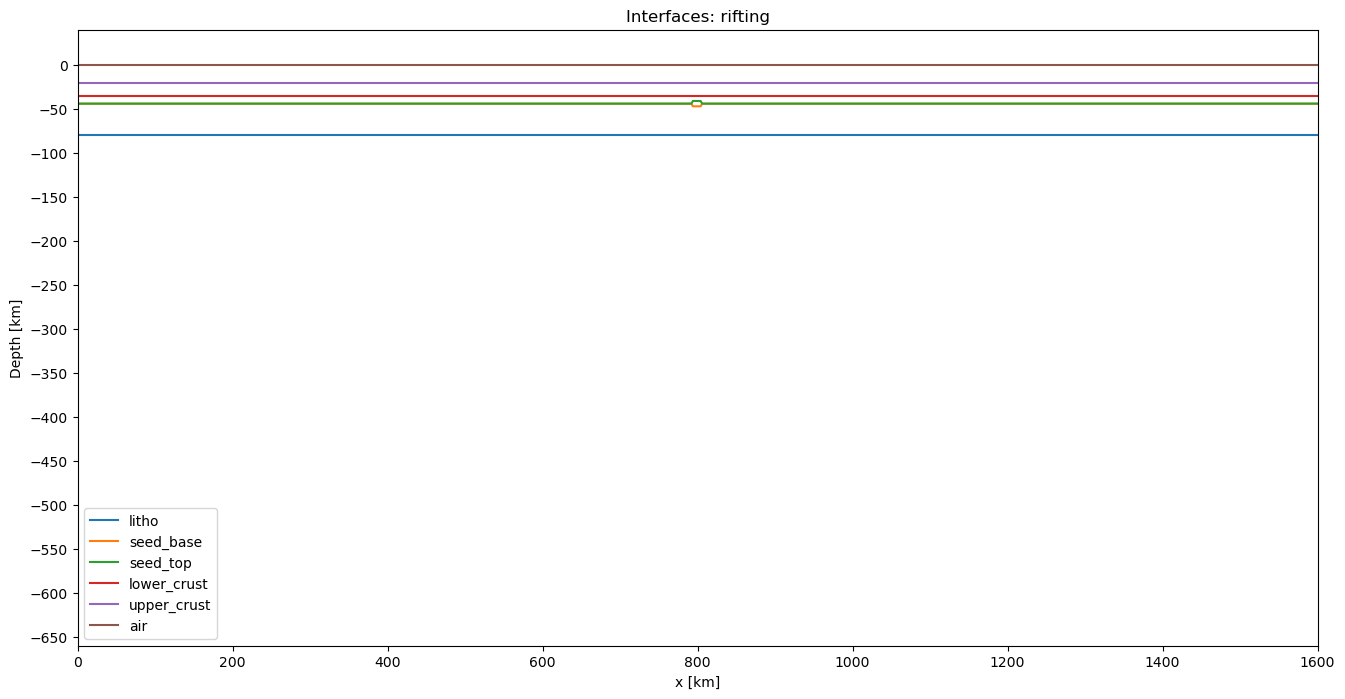

In [43]:
#Plot interfaces
fig, ax = plt.subplots(figsize=(16, 8))

for label, layer in interfaces.items():
    ax.plot(x / 1e3, (-layer + thickness_sa) / 1e3, label=f"{label}")

ax.set_yticks(np.arange(-Lz / 1e3, 1 / 1e3, 50))
ax.set_xlim([0, Lx/1000])
ax.set_ylim([(-Lz + thickness_sa) / 1e3, 0 + thickness_sa / 1e3])

ax.set_xlabel("x [km]")
ax.set_ylabel("Depth [km]")

plt.title("Interfaces: " + scenario_kind)
plt.legend()

plt.show()

#### Create the interface file

The interface file contain the layer properties and the interface's depth between these layers. 

Layer properties:
* Compositional factor (C)
* Density (rho)
* Radiogenic heat (H)
* Pre-exponential scale factor (A)
* Power law exponent (n)
* Activation energy (Q)
* Activation volume (v)

In [23]:
# Define the radiogenic heat for the upper and lower crust in W/kg:
Huc = 2.5e-6 / 2700.0
Hlc = 0.8e-6 / 2800.0

# Create and save the interface file:
if(scenario_kind == 'accordion_lit_hetero'):
    with open("interfaces.txt", "w") as f:

        rheology_mlit = 'dry' #rheology of lithospheric mantle: dry olivine or wet olivine
        if(rheology_mlit == 'dry'):
                layer_properties = f"""
                    C   {C_ast}   {Clitl}    {Clitc}     {Clc}       {C_uc}      {C_air}
                    rho 3378.0    3354.0     3354.0      2800.0      2700.0      1.0
                    H   {Hast}    9.0e-12    9.0e-12     {Hlc}       {Huc}       0.0
                    A   1.393e-14 2.4168e-15 2.4168e-15  8.574e-28   8.574e-28   1.0e-18
                    n   3.0       3.5        3.5         4.0         4.0         1.0
                    Q   429.0e3   540.0e3    540.0e3     222.0e3     222.0e3     0.0
                    V   15.0e-6   25.0e-6    25.0e-6     0.0         0.0         0.0
                """

        if(rheology_mlit == 'wet'):
            layer_properties = f"""
                C   {C_ast}   {Clitl}    {Clitc}    {Clc}       {C_uc}      {C_air}
                rho 3378.0    3354.0     3354.0     2800.0      2700.0      1.0
                H   {Hast}    9.0e-12    9.0e-12    {Hlc}       {Huc}       0.0
                A   1.393e-14 1.393e-14  1.393e-14  8.574e-28   8.574e-28   1.0e-18
                n   3.0       3.0        3.0        4.0         4.0         1.0
                Q   429.0e3   429.0e3    429.0e3    222.0e3     222.0e3     0.0
                V   15.0e-6   15.0e-6    15.0e-6    0.0         0.0         0.0
            """

    for line in layer_properties.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

    # layer interfaces
    data = -1 * np.array(tuple(interfaces.values())).T
    np.savetxt(f, data, fmt="%.1f")
    
else: 
    with open("interfaces.txt", "w") as f:
        rheology_mlit = 'dry' #rheology of lithospheric mantle: dry olivine or wet olivine
        
        if(rheology_mlit == 'dry'):
            layer_properties = f"""
                C   {C_ast}   {C_mlit}   {C_seed}   {C_mlit}   {C_lc}      {C_uc}      {C_air}
                rho 3378.0    3354.0     3354.0     3354.0     2800.0      2700.0      1.0
                H   {Hast}    9.0e-12    9.0e-12    9.0e-12    {Hlc}       {Huc}       0.0
                A   1.393e-14 2.4168e-15 2.4168e-15 2.4168e-15 8.574e-28   8.574e-28   1.0e-18
                n   3.0       3.5        3.5        3.5        4.0         4.0         1.0
                Q   429.0e3   540.0e3    540.0e3    540.0e3    222.0e3     222.0e3     0.0
                V   15.0e-6   25.0e-6    25.0e-6    25.0e-6    0.0         0.0         0.0
            """

        if(rheology_mlit == 'wet'):
            layer_properties = f"""
                C   {C_ast}   {C_mlit}   {C_seed}   {C_mlit}   {C_lc}      {C_uc}      {C_air}
                rho 3378.0    3354.0     3354.0     3354.0     2800.0      2700.0      1.0
                H   {Hast}    9.0e-12    9.0e-12    9.0e-12    {Hlc}       {Huc}       0.0
                A   1.393e-14 1.393e-14  1.393e-14  1.393e-14  8.574e-28   8.574e-28   1.0e-18
                n   3.0       3.0        3.0        3.0        4.0         4.0         1.0
                Q   429.0e3   429.0e3    429.0e3    429.0e3    222.0e3     222.0e3     0.0
                V   15.0e-6   15.0e-6    15.0e-6    15.0e-6    0.0         0.0         0.0
            """

        for line in layer_properties.split("\n"):
            line = line.strip()
            if len(line):
                f.write(" ".join(line.split()) + "\n")

        # layer interfaces
        data = -1 * np.array(tuple(interfaces.values())).T
        np.savetxt(f, data, fmt="%.1f")

## Create initial temperature field

### `Preset` option as `False`

If the `preset == False`, the initial temperature structure is depth dependent and is 0°C at the surface and 1300°C at the base of the lithosphere at 130 km.
With these boundary conditions, the initial temperature structure in the interior of the lithosphere is given by the solution of the following equation:

$$ \kappa \frac{\partial^2 T(z)}{\partial z^2} + \frac{H(z)}{c_p} = 0$$

where $H(z)$ is the internal heat production of the different layers.

The sublithospheric temperature follows an adiabatic increase up to the bottom of the model:

$$T = T_p exp (g \alpha z ∕c_p)$$

Where $T_p$ is the potential temperature for the mantle, $g$ is the gravity aceletation, $\alpha$ is the volumetric expansion coefficient, $c_p$ is the specific heat capacity.

For the experiments of LAB stability ou can increase sublithospheric (asthenospheric) temperature `Ta` by setting a value for `DeltaT`.

### `Preset` option as `True`
If the `preset == True` the temperature field is extracted from an external `scenario` and interpolated in the new grid accordind to the `interp_method` that can be setted bellow as:
- `'horizontal_mean'`: calculate the horizontal mean* for each depth of the external temperature field and interpolate in the new mesh using `interp1d` from `scipy`.<br>
    *If the external `scenario` is a `'stab_keel'`, you can set `keel_center == True` in Setup section above to select the cratonic region to calculate the horizontal mean.
- `'interp2d'`: interpolate the temperature field on the new grid using `interp2d` from `scipy` setting `interp_kind` as  `'linear'`, `'cubic'` or `'quintic'` as interpolation method.

You can handle with the temperature of the vertical boundaries by setting `bound` in the cell bellow as:
- `'mean'` (recommended): use the horizontal mean temperature of the external scenario interpolated in the new grid <br>
    or
- `'original'`: use the original boundary temperature from the external scenario interpolated in the new grid.

In [24]:
##############################################################################
# Initial temperature field
##############################################################################
 
print('Initial temperature field setup:')
scenario_infos.append('Initial temperature field setup:')


if(preset == False):
    kappa = 1.0e-6 # m^2/s
    ccapacity = 1250 # J/(kg K)
    tem_p = 1262  # °C
    g = -10 # m/s^2
    alpha = 3.28e-5 # 1/K
    
    temp_z = 1300 * (z - thickness_sa) / (thickness_litho)  # Temperature
    # temp_z = 1300 * (z - thickness_sa) / (130*1.0E3)  # Temperature of 1300 isotherm bellow the lithosphere

    ccapacity = 1250*1.0 #937.5=75% #J/kg/K? #DEFAULT.
    # ccapacity = 1250*0.75 #937.5=75% #J/kg/K?
    # ccapacity = 750
    print('Increase in mantle basal temperature (Ta): '+str(DeltaT) + ' oC')
    scenario_infos.append('Increase in mantle basal temperature (Ta): '+str(DeltaT)+' oC')

    TP = 1262 #mantle potential temperature
    # TP = 1350
    # TP = 1400
    # TP = 1450
    print('Assumed mantle Potential Temperature: '+str(TP)+' oC')
    scenario_infos.append('Assumed mantle Potential Temperature: '+str(TP)+' oC')

    Ta = (TP / np.exp(-10 * 3.28e-5 * (z - thickness_sa) / ccapacity)) + DeltaT
    # Ta = 1262 / np.exp(-10 * 3.28e-5 * (z - thickness_sa) / ccapacity)

    temp_z[temp_z < 0.0] = 0.0
    cond1 = Ta<temp_z #VICTOR
    temp_z[temp_z > Ta] = Ta[temp_z > Ta]

    # kappa = 0.75*1.0e-6 #thermal diffusivity
    kappa = 1.0e-6 #thermal diffusivity

    H = np.zeros_like(temp_z)

    cond = (z >= thickness_sa) & (z < thickness_upper_crust + thickness_sa)  # upper crust
    H[cond] = Huc

    cond = (z >= thickness_upper_crust + thickness_sa) & (
        z < thickness_lower_crust + thickness_upper_crust + thickness_sa
    )  # lower crust
    H[cond] = Hlc

    temp_z_aux = np.copy(temp_z)
    t = 0
    dt = 5000
    dt_sec = dt * 365 * 24 * 3600
    # cond = (z > thickness_sa + thickness_litho) | (T == 0)  # (T > 1300) | (T == 0) #OLD
    cond = cond1 | (temp_z == 0)  # (T > 1300) | (T == 0) #VICTOR
    dz = Lz / (Nz - 1)

    
    while t < 500.0e6:
        temp_z[1:-1] += (
            kappa * dt_sec * ((temp_z[2:] + temp_z[:-2] - 2 * temp_z[1:-1]) / dz ** 2)
            + H[1:-1] * dt_sec / ccapacity
        )
        temp_z[cond] = temp_z_aux[cond]
        t = t + dt
    
    temp_z = np.ones_like(X) * temp_z[:, None] #(Nz, Nx)

    print('shape temp_z: ', np.shape(temp_z))

    # Save the initial temperature file
    np.savetxt("input_temperature_0.txt", np.reshape(temp_z, (Nx * Nz)), header="T1\nT2\nT3\nT4")

else:
    dz = Lz / (Nz - 1)

    print('Used external scenario: ', scenario)
    scenario_infos.append('Used external scenario: ' + scenario)

    fpath = machine_path + '/Doutorado/cenarios/mandyoc/' + scenario
    
    Nx_aux, Nz_aux, Lx_aux, Lz_aux = read_params(fpath)

    x_aux = np.linspace(0, Lx_aux, Nx_aux)
    z_aux = np.linspace(Lz_aux, 0, Nz_aux)
    xx_aux, zz_aux  = np.meshgrid(x_aux, z_aux)

    steps = sorted(glob.glob(fpath+"time_*.txt"), key=os.path.getmtime)
    step_final = int(steps[-1].split('/')[-1][5:-4]) #step of final thermal structure
    
    time_fname = fpath + 'time_' + str(step_final) + '.txt'
    time = np.loadtxt(time_fname, usecols=2, max_rows=1)

    Datai = read_data('temperature', step_final, Nz_aux, Nx_aux, fpath) #(read final thermal structure (Nz, Nx)
    

    #Setting procedure with external temperature field. Choose between:
        ##Use the horizontal mean of temperature from final step of used scenario (horizontal_mean)
        ##or
        ##Use the original thermal state used as input interpolated on new grid Nx x Nz (interp2d)

    # interp_method = 'horizontal_mean' #using interp1d
    interp_method = 'interp2d'
    
    print('Interpolation of temperature field using: '+interp_method)
    scenario_infos.append('Interpolation of temperature field using: '+interp_method)
    
    #Setting temperature on vertical boundaries. Choose between:
        ##Use the mean temperature from final step of used scenario (mean)
        ##or
        ##Use the original thermal state used as input interpolated on new Nz (original)
    bound = 'mean'
    # bound = 'original'

    print('Temperature of boundaries: ' + bound)
    scenario_infos.append('Temperature of boundaries: ' + bound)

    if(interp_method == 'horizontal_mean'):

        print('Keel center: '+str(keel_center))
        scenario_infos.append('Keel center: '+str(keel_center))

        if(keel_center==True):
            xregion = (xx_aux>=700.0e3) & (xx_aux <= 900.0e3) #craton
            Data_region = Datai[xregion].reshape(Nz_aux, len(xregion[0][xregion[0]==True]))
            datai_mean = np.mean(Data_region, axis=1) #horizontal mean
        else:
            datai_mean = np.mean(Datai, axis=1) #horizontal mean

        f = interp1d(z_aux, datai_mean) #funcion to interpolate the temperature field
        datai_mean_interp = f(z) #applying the function to obtain the temperature field to the new mesh
        zcond = z <= 40.0e3
        datai_mean_interp[datai_mean_interp <= 1.0e-7] = 0.0 #dealing with <=0 values inherited from interpolation
        datai_mean_interp[zcond] = 0.0

        temp_z = np.zeros((Nx, Nz)) #(Nx, Nz) = transpose of original shape (Nz, Nx)
        
        for i in range(Nx): #len(Nx)
            temp_z[i, :] = datai_mean_interp

        temp_z = temp_z.T #(Nz,Nx): transpose temp_z to plot below
        print('shape temp_z: ', np.shape(temp_z))
    
    else:
        interp_kind = 'linear'
        # interp_kind = 'cubic'
        # interp_kind = 'quintic'
        print('Interpolation method: ' + interp_kind)
        scenario_infos.append('Interpolation method: ' + interp_kind)

        f = interp2d(x_aux, z_aux, Datai, kind=interp_kind)
        temper_interp = f(x, z) #(Nz, Nx)
        temper_interp[temper_interp <= 1.0e-7] = 0.0 #dealing with <=0 values inherited from interpolation
        
        if(bound == 'mean'):
            #Calc horizontal mean from interpolated field
            temper_interp_mean = np.mean(temper_interp, axis=1)
            zcond = z >= 660.0e3 #temperature field is from bottom to top
            temper_interp_mean[zcond] = 0.0
            
            if(mean_litho==True):
                zcond1 = (z >= 560.0e3) & (z < 660.0e3)
                temper_interp = temper_interp.T #Change to (Nx, Nz)
                
                for i in range(Nx): #len(Nx)
                    temper_interp[i][zcond1] = temper_interp_mean[zcond1]

                temper_interp = temper_interp.T #Return to (Nz, Nx)

            #Apply horizontal mean to vertical boundaries
            for i in range(Nz):
                temper_interp[i][0] = temper_interp_mean[i]
                temper_interp[i][-1] = temper_interp_mean[i]

        else:
            #Cat the initial thermal state from scenario
            step_initial = int(steps[0].split('/')[-1][5:-4])
            time_fname = fpath + 'time_' + str(step_initial) + '.txt'
            time = np.loadtxt(time_fname, usecols=2, max_rows=1)
            T0i = read_data('temperature', step_initial, Nz_aux, Nx_aux, fpath)

            #interpolate in new grid
            T0 = T0i[:, 0]
            f = interp1d(z_aux, T0)
            T0_interp = f(z)
            T0_interp[T0_interp<=1.0e-7] = 0.0
            T0_interp = T0_interp[::-1]
            
            #apply to boundaries
            for i in range(Nz):
                temper_interp[i][0] = T0_interp[i]
                temper_interp[i][-1] = T0_interp[i]
         
        temp_z = temper_interp[::-1]
        print('shape Temper: ', np.shape(temp_z))

    np.savetxt("input_temperature_0.txt", np.reshape(temp_z, (Nx * Nz)), header="T1\nT2\nT3\nT4")

Initial temperature field setup:
Increase in mantle basal temperature (Ta): 0 oC
Assumed mantle Potential Temperature: 1262 oC
shape temp_z:  (201, 801)


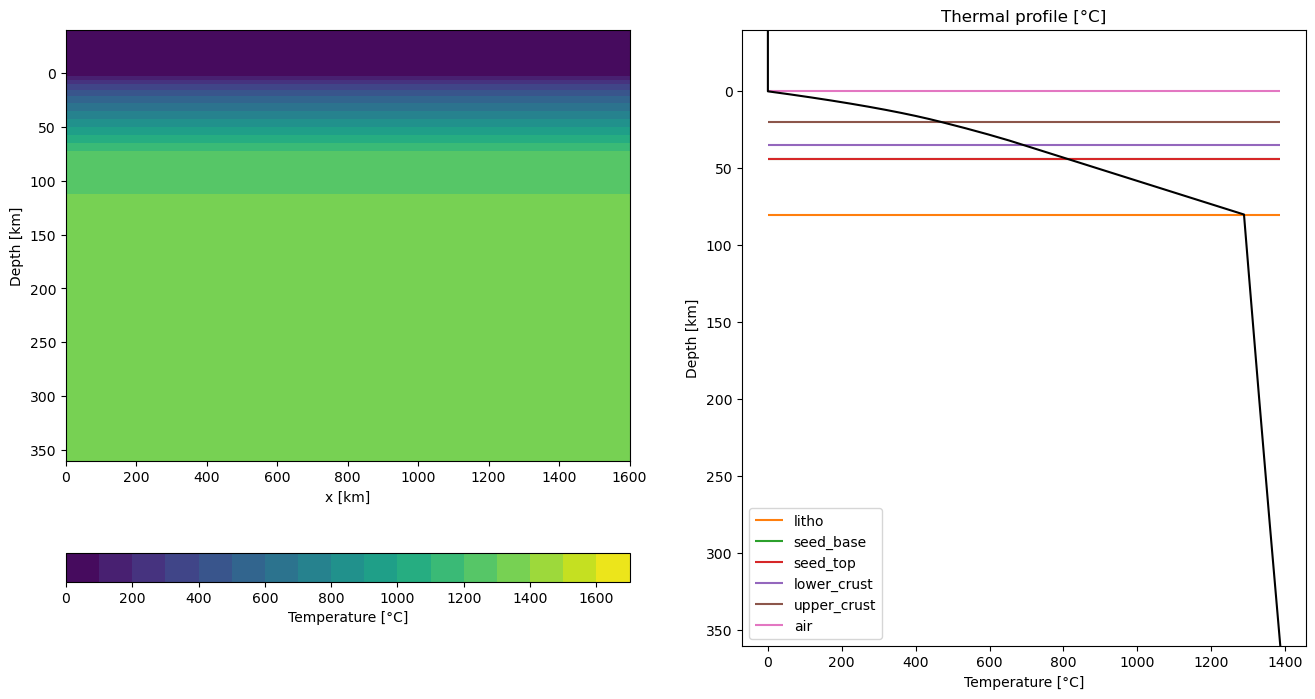

In [25]:
plt.close()
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Temperature field:
im1 = ax0.contourf(
    X / 1.0e3,
    (Z - thickness_sa) / 1.0e3,
    temp_z,
    levels=np.arange(0, 1800, 100)
    )

ax0.set_ylim((Lz - thickness_sa) / 1.0e3, -thickness_sa / 1e3)
ax0.set_ylabel("Depth [km]")
ax0.set_xlabel("x [km]")
cbar = fig.colorbar(im1, orientation='horizontal', ax=ax0)
cbar.set_label("Temperature [°C]")

# Profile:
ax1.set_title("Thermal profile [°C]")
ax1.plot(temp_z[:, 0], (z - thickness_sa) / 1.0e3, "-k")
# Add interfaces:
code = 0
for label in list(interfaces.keys()):
    code += 1
    color = "C" + str(code)
    ax1.hlines(
        (interfaces[label][0] - thickness_sa) / 1.0e3,
        np.min(temp_z[:, 0]),
        np.max(temp_z[:, 0]),
        label=f"{label}",
        color=color,
    )

ax1.set_ylim((Lz - thickness_sa) / 1.0e3, -thickness_sa / 1e3)
ax1.set_xlabel("Temperature [°C]")
ax1.set_ylabel("Depth [km]")

plt.legend(loc="lower left")
plt.show()

### Boundary condition - Velocity

The horizontal velocity field along the left and right borders of the domain presents two layers:
* Constant velocity with depth at $0 ≤ z < h_c$
* Linearly variable velocity with depth at $h_c ≤ z ≤ h_c + h_a$

where $h_c = 150$ km is the thickness of the upper layer with constant velocity, corresponding to the lithosphere $h_{litho} = 130$ km and part of the asthenosphere, and $h_a = 110$ km corresponds to the remaining asthenospheric portion of the model until the bottom
of the model, where the horizontal velocity at the borders of the model varies linearly with depth.
Therefore, the sum $h_c + h_a$ represents the total thickness of the model without the “sticky air” layer.

In [26]:
velocity = 1.0 #cm/yr

# Convert cm to m and also divide by 2
velocity = velocity / (100.0 * 2.0) #m/yr

# Convert m/yr to m/s:
velocity_L = velocity / (365 * 24 * 3600)

# Convert cm/year to m/s:
# velocity_L = 0.005 / (365 * 24 * 3600) #original

# Define the thickness with constant velocity in meters
thickness_v_const = 150.0e3

thickness_a = Lz - thickness_sa - thickness_v_const

velocity_R = 2 * velocity_L * (thickness_v_const + thickness_a) / thickness_a

fac_air = 10.0e3

In [27]:
# Create  horizontal and vertical velocity:
VX, VZ = np.zeros_like(X), np.zeros_like(X)

Velocity for the left side (`x == 0`):

In [28]:
# When 0 <= z <= (h_v_const + thickness_sa), VX is zero.
# When (h_v_const * thickness_sa) <= z <= Lz, VX goes from 0 to vR.
cond = (Z > thickness_v_const + thickness_sa) & (X == 0)
VX[cond] = velocity_R * (Z[cond] - thickness_v_const - thickness_sa) / thickness_a

Velocity for the right side (`x == Lx`):

In [29]:
# When 0 <= z <= (h_v_const + thickness_sa), VX is 2vL
# When (h_v_const + thickness_sa) < z <= Lz, VX goes from 2vL to -vR + 2vL
cond = (Z > thickness_v_const + thickness_sa) & (X == Lx)
VX[cond] = -velocity_R * (Z[cond] - thickness_v_const - thickness_sa) / thickness_a

VX[X == Lx] += 2 * velocity_L

VX[Z <= thickness_sa - fac_air] = 0

Due to the mass conservation is assumed, the sum of the integrals over the boundaries (material flow) must be zero.

In [30]:
# For the left side:
v0= VX[(X == 0)]
sum_velocity_left = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0

# For the right side:
vf = VX[(X == Lx)]
sum_velocity_right = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0

dz = Lz / (Nz - 1)
diff = (sum_velocity_right - sum_velocity_left) * dz

print("Sum of the integrals over the boundary is:", diff)

Sum of the integrals over the boundary is: 2.8538812785388226e-06


If the sum of the integrals over the boundaries is not zero, because rounding errors, we add a very small flow on the top to compensate this difference.
In fact this is a very small correction.

In [31]:
vv = -diff / Lx

VZ[Z == 0] = vv

Create and save the initial velocity file:

In [32]:
VVX = np.copy(np.reshape(VX, Nx * Nz))
VVZ = np.copy(np.reshape(VZ, Nx * Nz))

velocity = np.zeros((2, Nx * Nz))

velocity[0, :] = VVX
velocity[1, :] = VVZ

velocity = np.reshape(velocity.T, (np.size(velocity)))

np.savetxt("input_velocity_0.txt", velocity, header="v1\nv2\nv3\nv4")

For Wilson cycle experiments we need to change reescale the velocity field to simulate convergent process by setting `variable_bcv == True` in Step section above to create a `scale_bcv.txt` file specifying:
- Number of instants that velocity fild must be reescaled
- Time_instant_in_Myr scale_factor_of_velocity_field

In [33]:
if(variable_bcv == True):
        var_bcv = f""" 1
        30.0 -1.0

        """
        # var_bcv = f""" 2
        # 50.0 -1.0
        # 150  -1.0E-15
        # """
        # Create the parameter file
        with open("scale_bcv.txt", "w") as f:
            for line in var_bcv.split("\n"):
                line = line.strip()
                if len(line):
                    f.write(" ".join(line.split()) + "\n")

Plot the velocity profile for the boundaries:

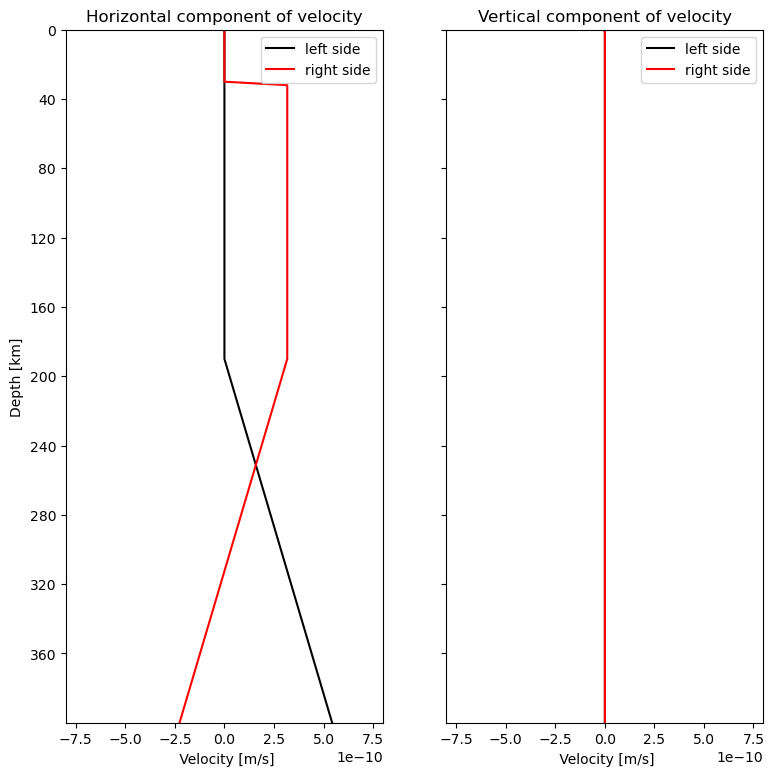

In [34]:
plt.close()
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(9, 9), sharey=True)

ax0.plot(VX[:, 0], (z) / 1e3, "k-", label="left side")
ax1.plot(VZ[:, 0], (z) / 1e3, "k-", label="left side")

ax0.plot(VX[:, -1], (z ) / 1e3, "r-", label="right side")
ax1.plot(VZ[:, -1], (z) / 1e3, "r-", label="right side")

ax0.legend()
ax1.legend()

ax0_xlim = ax0.get_xlim()
ax1_xlim = ax1.get_xlim()

ax0.set_yticks(np.arange(-40, Lz / 1e3, 40))
#ax1.set_yticks(np.arange(0, Lz / 1000, 20))

ax0.set_ylim([Lz / 1e3 , 0])


ax0.set_xlim([-8e-10, 8e-10])
ax1.set_xlim([-8e-10, 8e-10])

ax0.set_xlabel(" Velocity [m/s]")
ax1.set_xlabel(" Velocity [m/s]")
ax0.set_ylabel("Depth [km]")

ax0.set_title("Horizontal component of velocity")
ax1.set_title("Vertical component of velocity")

plt.show()

# Surface process

Setting `sp_surface_processes == True` and `sp_surface_processes == True` in Step section above creates a `precipitation.txt` file. The procedure is the same adopted by Silva and Sacek (2022):

$$\dot e(x) = k_{\mathrm{sp}} e_f(x)\mathrm{\ \ for \ }t>10\mathrm{\ Myr,}$$

where, $k_{\mathrm{sp}}$ is the maximum denudation rate and $e_f$ is the spatial control of denudation, given by:


$$e_f(x) = \mathrm{exp}\left[-\frac{(x - x_c)^6}{x_{\sigma}^6}\right]\mathrm{.}$$

$x_{\sigma}$ controls the spatial extent of denudation from the center of the model at position $x = x_c$, and $t$ is time since the onset of the numerical simulation. Erosion acts only if the topographic surface is above sea level ($h > h_{\mathrm{sl}}$).

Setting `climate_change_from_ascii == True` in Step section above you can choose the instants to the action the surface process and the scale factor of the precipitation function by modifying `climate` as:

`climate = f'''
     N_instants
     instant_0 scale_0
     ...
     instant_i scale_i
     ...
     instant_N scale_N
 '''`
 
where:
- `N_instant `: Number of instants that surface process must be reescaled
- `instant_ `: Time instant in Myr scale factor of surface process
- `scale_i`: scale factor of surface process



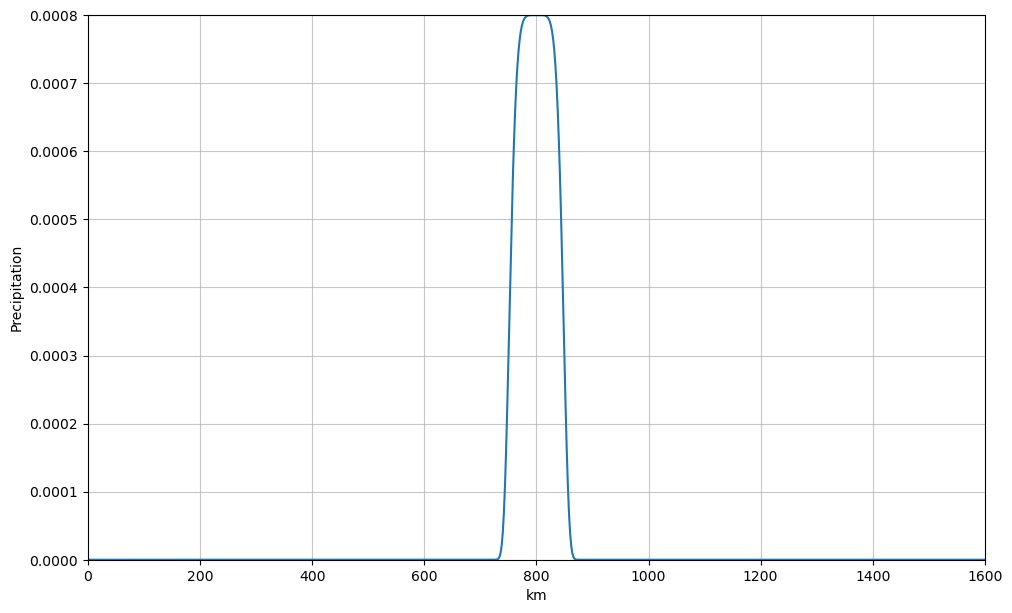

In [35]:
sp_surface_processes = True
climate_change_from_ascii = True
precipitation_profile_from_ascii = True

if(sp_surface_processes == True):
    if(climate_change_from_ascii == True):
        #When climate effects will start to act - scaling to 1
        climate = f'''
                2
                0 0.0
                10 0.02
            '''

        with open('climate.txt', 'w') as f:
            for line in climate.split('\n'):
                line = line.strip()
                if len(line):
                    f.write(' '.join(line.split()) + '\n')

    if(precipitation_profile_from_ascii ==True):
        #Creating precipitation profile

        # prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/8)**6) #original
        # prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(8*2))**6) #100 km
        prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(8*4))**6) #50 km
        np.savetxt("precipitation.txt", prec, fmt="%.8f")
        
        plt.close()
        plt.figure(figsize=(10, 6), constrained_layout=True)
        plt.xlim([0, Lx/1.0E3])
        plt.ylim([0, np.max(prec)])
        plt.xlabel("km")
        plt.ylabel("Precipitation")
        plt.plot(x/1000,prec)
        plt.grid(':k', alpha=0.7)

        figname='precipitation_profile.png'
        plt.savefig(figname, dpi=300)
        plt.show()

### Create the parameter file

In [36]:
params = f"""
nx = {Nx}
nz = {Nz}
lx = {Lx}
lz = {Lz}


# Simulation options
multigrid                           = 1             # ok -> soon to be on the command line only
solver                              = direct        # default is direct [direct/iterative]
denok                               = {denok}       # default is 1.0E-4
particles_per_element               = {particles_per_element}          # default is 81
particles_perturb_factor            = 0.7           # default is 0.5 [values are between 0 and 1]
rtol                                = 1.0e-7        # the absolute size of the residual norm (relevant only for iterative methods), default is 1.0E-5
RK4                                 = Euler         # default is Euler [Euler/Runge-Kutta]
Xi_min                              = 1.0e-7       # default is 1.0E-14
random_initial_strain               = 0.3           # default is 0.0
pressure_const                      = -1.0          # default is -1.0 (not used) - useful only in horizontal 2D models
initial_dynamic_range               = True         # default is False [True/False]
periodic_boundary                   = {periodic_boundary}         # default is False [True/False]
high_kappa_in_asthenosphere         = {high_kappa_in_asthenosphere}         # default is False [True/False]
K_fluvial                           = 2.0e-7        # default is 2.0E-7
m_fluvial                           = 1.0           # default is 1.0
sea_level                           = 0.0           # default is 0.0
basal_heat                          = 0.0          # default is -1.0

# Surface processes
sp_surface_tracking                 = {sp_surface_tracking}         # default is False [True/False]
sp_surface_processes                = {sp_surface_processes}         # default is False [True/False]
sp_dt                               = 1.0e5        # default is 0.0
sp_d_c                              = 1.0          # default is 0.0
plot_sediment                       = False         # default is False [True/False]
a2l                                 = True          # default is True [True/False]

free_surface_stab                   = True          # default is True [True/False]
theta_FSSA                          = 0.5           # default is 0.5 (only relevant when free_surface_stab = True)

# Time constrains
step_max                            = 5000          # Maximum time-step of the simulation
time_max                            = {time_max}     # Maximum time of the simulation [years]
dt_max                              = 10.0e3      # Maximum time between steps of the simulation [years]
step_print                          = {step_print}            # Make file every <step_print>
sub_division_time_step              = 0.5           # default is 1.0
initial_print_step                  = 0             # default is 0
initial_print_max_time              = 1.0e6         # default is 1.0E6 [years]

# Viscosity
viscosity_reference                 = 1.0e26        # Reference viscosity [Pa.s]
viscosity_max                       = 1.0e25        # Maximum viscosity [Pa.s]
viscosity_min                       = 1.0e18        # Minimum viscosity [Pa.s]
viscosity_per_element               = constant      # default is variable [constant/variable]
viscosity_mean_method               = arithmetic      # default is harmonic [harmonic/arithmetic]
viscosity_dependence                = pressure      # default is depth [pressure/depth]

# External ASCII inputs/outputs
interfaces_from_ascii               = True          # default is False [True/False]
n_interfaces                        = {len(interfaces.keys())}           # Number of interfaces int the interfaces.txt file
variable_bcv                        = {variable_bcv}         # default is False [True/False]
temperature_from_ascii              = True         # default is False [True/False]
velocity_from_ascii                 = {velocity_from_ascii}         # default is False [True/False]
binary_output                       = False         # default is False [True/False]
sticky_blanket_air                  = True         # default is False [True/False]
precipitation_profile_from_ascii    = {precipitation_profile_from_ascii}         # default is False [True/False]
climate_change_from_ascii           = {climate_change_from_ascii}         # default is False [True/False]


print_step_files                    = {print_step_files}          # default is True [True/False]
checkered                           = False         # Print one element in the print_step_files (default is False [True/False])

sp_mode                             = 5             # default is 1 [0/1/2]

geoq                                = on            # ok
geoq_fac                            = 100.0           # ok

# Physical parameters
temperature_difference              = 1500.         # ok
thermal_expansion_coefficient       = 3.28e-5       # ok
thermal_diffusivity_coefficient     = 1.0e-6        # ok
gravity_acceleration                = 10.0          # ok
density_mantle                      = 3300.         # ok
external_heat                       = 0.0e-12       # ok
heat_capacity                       = 1250.         # ok

non_linear_method                   = on            # ok
adiabatic_component                 = on            # ok
radiogenic_component                = on            # ok

# Velocity boundary conditions
top_normal_velocity                 = fixed         # ok
top_tangential_velocity             = free          # ok
bot_normal_velocity                 = fixed         # ok
bot_tangential_velocity             = free          # ok
left_normal_velocity                = {left_normal_velocity}         # ok
left_tangential_velocity            = {left_tangential_velocity}         # ok
right_normal_velocity               = {right_normal_velocity}         # ok
right_tangential_velocity           = {right_tangential_velocity}         # ok

surface_velocity                    = 0.0e-2        # ok
multi_velocity                      = False         # default is False [True/False]

# Temperature boundary conditions
top_temperature                     = {top_temperature}         # ok
bot_temperature                     = {bot_temperature}         # ok
left_temperature                    = {bot_temperature}          # ok
right_temperature                   = {bot_temperature}         # ok

rheology_model                      = 9             # ok
T_initial                           = 3             # ok

"""
# Create the parameter file
with open("param.txt", "w") as f:
    for line in params.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

# Creating a file containing the scenario's main characteristics

In [37]:
np.savetxt('infos_' + scenario_kind + '.txt', scenario_infos, fmt="%s")

## Run the model 

In this example, mandyoc use the following flags: 

* -seed 0,2
* -strain_seed 0.0,1.0 

You can run the model as:

```
mpirun -n NUMBER_OF_CORES mandyoc -seed 0,2 -strain_seed 0.0,1.0 
```

*You have to change NUMBER_OF_CORES.*

Run the cell bellow to create a shell script that to run this example

In [38]:
NUMBER_OF_CORES = 4
run = f'''
        #!/bin/bash
        mpirun -n {NUMBER_OF_CORES} mandyoc -seed 0,2 -strain_seed 0.0,1.0
       '''

with open('run.sh', 'w') as f:
    for line in run.split('\n'):
        line = line.strip()
        if len(line):
            f.write(' '.join(line.split()) + '\n')

In [39]:
scenario_infos

['SCENARIO INFOS:',
 ' ',
 'Type of experiment: Rifting experiment',
 ' ',
 'Viscosity scale factors (C):',
 'C asthenosphere: 1.0',
 'C mantle lithosphere: 10.0',
 'C seed: 1.0',
 'C lower crust: 1.0',
 'C upper crust: 1.0',
 'C air: 1.0',
 ' ',
 'Preset of initial temperature field: False',
 'Increase in mantle basal temperature (Ta): 0 oC',
 'Seed extra fragil: False',
 'Use horizontal mean of temperature from preset in lithosphere: False',
 'High kappa in asthenosphere: False',
 'Surface process: False',
 'Climate change: False',
 'Velocity field: True',
 ' ',
 'Domain parameters:',
 'Lx: 1600.0 km',
 'Lz: 400.0 km',
 'Nx: 801',
 'Nz: 201',
 'Resolution dx x dz: 2x2 km2',
 ' ',
 'Layers thickness:',
 'Air: 40.0 km',
 'Upper crust: 20.0 km',
 'Lower crust: 15.0 km',
 'Lithospheric Mantle: 45.0 km',
 'Lithosphere: 80.0 km',
 ' ',
 'Initial temperature field setup:',
 'Increase in mantle basal temperature (Ta): 0 oC',
 'Assumed mantle Potential Temperature: 1262 oC']